In [1]:
# %% load libs:
from collections import defaultdict
from os import path as op
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.lib.npyio import load
import scipy

import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from scipy import stats

import mne
from mne import EvokedArray
# from mne.epochs import concatenate_epochs
from mne.decoding import (SlidingEstimator,  # GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm

from library import config, helpers

Study path is set to: /raven/ptmp/fklotzsche/Experiments/vMemEcc


In [3]:
# %% Functions:


def plot_score_per_factor(
    factor,
    data,
    scoring="roc_auc",
    sign_clusters=[],
    p_lvl=0.05,
    ci_func=("ci", 95),
    ylims=None,
    plt_dict=None,
    ax=None,
    n_boot=1000,
):
    """
    This function plots the decoding score over time (per factor).

    Parameters
    ----------
    factor : str
        The name of the factor to plot. Can be "Load", "Ecc", or "All".
    data : pandas.DataFrame
        The dataframe containing the data to plot.
    scoring : str, optional
        The scoring method to use.
    sign_clusters : list, optional
        A list of tuples containing the start and end of significant clusters.
    p_lvl : float, optional
        The p-value threshold for significance.
    ci_func : tuple, optional
        The function to use for calculating the confidence interval.
    ylims : tuple, optional
        The y-axis limits.
    plt_dict : dict, optional
        A dictionary containing the plotting parameters.
    ax : matplotlib.axes._subplots.AxesSubplot, optional
        The axes to plot on.
    n_boot : int, optional
        The number of bootstrap samples to use.

    Returns
    -------
    matplotlib.axes._subplots.AxesSubplot
        The axes with the plot.
    """

    sns.lineplot(
        x="time",
        y="score",
        hue=factor,
        data=data,
        n_boot=n_boot,
        errorbar=ci_func,
        palette=config.colors,
        ax=ax,
        linewidth=0.5,
        legend=False,
    )
    ytick_range = ax.get_ylim()
    if ylims is None:
        ylims = ytick_range
    ax.set(xlim=(plt_dict["xmin"], plt_dict["xmax"]), ylim=ylims)
    if scoring == "roc_auc":
        scoring_str = "ROC AUC"
    else:
        scoring_str = scoring
    ax.set_ylabel(scoring_str)
    ax.set_xlabel("Time (s)")
    ax.axvspan(
        plt_dict["t_stimon"], plt_dict["t_stimon"] + 0.2, color="grey", alpha=0.3
    )
    ax.axvspan(
        plt_dict["t_stimon"] + 2.2, plt_dict["t_stimon"] + 2.5, color="grey", alpha=0.3
    )
    ax.vlines(
        (plt_dict["t_stimon"], plt_dict["t_stimon"] +
         0.2, plt_dict["t_stimon"] + 2.2),
        ymin=ylims[0],
        ymax=ylims[1],
        linestyles="dashed",
        linewidth=0.5,
        color="black",
    )
    ax.hlines(
        0.5, xmin=plt_dict["xmin"], xmax=plt_dict["xmax"], linewidth=0.5, color="black"
    )
    p_lvl_str = "p < ." + str(p_lvl).split(".")[-1]
    if isinstance(sign_clusters, dict):
        for i, key in enumerate(sign_clusters):
            col = config.colors[key]
            for sc in sign_clusters[key]:
                xmin = sc[0]
                xmax = sc[-1]
                ax.hlines(
                    ylims[0] + (0.05 - ((i + 1) * 0.025) * np.ptp(ylims)),
                    xmin=xmin,
                    xmax=xmax,
                    color=col,
                    label=p_lvl_str,
                )

    else:
        for sc in sign_clusters:
            xmin = sc[0]
            xmax = sc[-1]
            ax.hlines(
                ytick_range[0] + 0.05 * np.ptp(ytick_range),
                xmin=xmin,
                xmax=xmax,
                color="purple",
                label=p_lvl_str,
            )
    handles, labels = ax.get_legend_handles_labels()
    n_sgn_clu = None if len(sign_clusters) <= 1 else -(len(sign_clusters))
    # ax.legend(handles=handles[1:n_sgn_clu+1], labels=labels[1:n_sgn_clu+1])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.setp(ax.collections, clip_on=False)


def load_decod_res_all(
    epo_part="stimon", signaltype="collapsed", scoring="roc_auc", picks_str=None
):
    """
    Load decoding results from disk across all eccentricities.

    Parameters
    ----------
    epo_part : str, optional
        Epoch part. Default: "stimon"
    signaltype : str, optional
        Signal type. Default: "collapsed"
    scoring : str, optional
        Scoring method. Default: "roc_auc"
    picks_str : str, optional
        Picks string. Default: None

    Returns
    -------
    data_dict : dict
        Dictionary with decoding results.
    """

    data_dict = dict()

    if picks_str is not None:
        picks_str_folder = picks_str
    else:
        picks_str_folder = ""

    if len(ecc_list) == 0:
        ecc_list = [""]
    for ecc in ecc_list:
        data_dict[ecc] = {}
        contrast_str = f"LoadLow{ecc}_vs_LoadHigh{ecc}"
        fpath = op.join(
            config.paths["06_decoding-sensorspace"],
            epo_part,
            signaltype,
            contrast_str,
            scoring,
            picks_str_folder,
            "scores",
        )
        fname = op.join(fpath, "scores_per_sub.npy")
        data_dict[ecc]["scores"] = np.load(fname)
        data_dict[ecc]["times"] = np.load(fname[:-4] + "__times" + ".npy")
        fpath = op.join(
            config.paths["06_decoding-sensorspace"],
            epo_part,
            signaltype,
            contrast_str,
            scoring,
            picks_str_folder,
            "patterns",
        )
        fname = op.join(fpath, "patterns_per_sub.npy")
        data_dict[ecc]["patterns"] = np.load(fname)
    return data_dict


def load_decod_res_per_ecc(
    sub_list_str,
    ecc_list=[],
    epo_part="stimon",
    signaltype="collapsed",
    scoring="roc_auc",
    picks_str=None,
    gen_str=None,
):
    """
    Load decoding results from disk for a given list of subjects and eccentricities.

    Parameters
    ----------
    sub_list_str : list of str
        List of subject IDs.
    ecc_list : list of str, optional
        List of eccentricities.
    epo_part : str, optional
        Epoch part. Default: "stimon"
    signaltype : str, optional
        Signal type. Default: "collapsed"
    scoring : str, optional
        Scoring method. Default: "roc_auc"
    picks_str : str, optional
        Picks string. Default: None
    gen_str : str, optional
        String identifying if any generalization (e.g., across time was applied). Not really implemented. Default: None

    Returns
    -------
    data_dict : dict
        Dictionary with decoding results.
    """
    data_dict = dict()
    if picks_str is not None:
        picks_str_folder = picks_str
    else:
        picks_str_folder = ""

    if gen_str is not None:
        gen_folder = gen_str
    else:
        gen_folder = ""

    if len(ecc_list) == 0:
        ecc_list = [""]
    for ecc in ecc_list:
        data_dict[ecc] = dict(scores=[], times=[], patterns=[])
        contrast_str = f"LoadLow{ecc}_vs_LoadHigh{ecc}"
        for subID in sub_list_str:
            fpath = op.join(
                config.paths["06_decoding-sensorspace"],
                epo_part,
                signaltype,
                contrast_str,
                gen_folder,
                scoring,
                picks_str_folder,
                "scores",
            )
            fname = op.join(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            data_dict[ecc]["scores"].append(scores_)

            if len(data_dict[ecc]["times"]) == 0:
                data_dict[ecc]["times"] = np.load(
                    fname[:-4] + "__times" + ".npy")
            else:
                assert np.all(
                    data_dict[ecc]["times"] == np.load(
                        fname[:-4] + "__times" + ".npy")
                )

            fpath = op.join(
                config.paths["06_decoding-sensorspace"],
                epo_part,
                signaltype,
                contrast_str,
                gen_folder,
                scoring,
                picks_str_folder,
                "patterns",
            )
            fname = op.join(fpath, f"{subID}-patterns_per_sub.npy")
            patterns_ = np.load(fname)
            data_dict[ecc]["patterns"].append(patterns_)

        data_dict[ecc]["scores"] = np.array(data_dict[ecc]["scores"])
        data_dict[ecc]["patterns"] = np.array(data_dict[ecc]["patterns"])

    return data_dict


def load_decod_res_chance_per_ecc(
    sub_list_str,
    ecc_list=[],
    epo_part="stimon",
    signaltype="collapsed",
    scoring="roc_auc",
    picks_str=None,
):
    """
    Same as `load_decod_res_per_ecc()` but loading the scores when run on shuffled data.
    """

    data_dict = dict()
    if picks_str is not None:
        picks_str_folder = picks_str
    else:
        picks_str_folder = ""

    if len(ecc_list) == 0:
        ecc_list = [""]
    for ecc in ecc_list:
        data_dict[ecc] = dict(
            scores_chance=[], times_chance=[], patterns_chance=[])
        contrast_str = f"LoadLow{ecc}_vs_LoadHigh{ecc}"
        for subID in sub_list_str:
            fpath = op.join(
                config.paths["06_decoding-sensorspace"],
                epo_part,
                signaltype,
                contrast_str,
                scoring,
                picks_str_folder,
                "labels_shuffled",
                "scores",
            )
            fname = op.join(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            data_dict[ecc]["scores_chance"].append(scores_)

            data_dict[ecc]["times_chance"] = np.load(
                fname[:-4] + "__times" + ".npy")
            if len(data_dict[ecc]["times_chance"]) == 0:
                data_dict[ecc]["times_chance"] = np.load(
                    fname[:-4] + "__times" + ".npy"
                )
            else:
                assert np.all(
                    data_dict[ecc]["times_chance"]
                    == np.load(fname[:-4] + "__times" + ".npy")
                )

            fpath = op.join(
                config.paths["06_decoding-sensorspace"],
                epo_part,
                signaltype,
                contrast_str,
                scoring,
                picks_str_folder,
                "labels_shuffled",
                "patterns",
            )
            fname = op.join(fpath, f"{subID}-patterns_per_sub.npy")
            patterns_ = np.load(fname)
            data_dict[ecc]["patterns_chance"].append(patterns_)

        data_dict[ecc]["scores_chance"] = np.array(
            data_dict[ecc]["scores_chance"])
        data_dict[ecc]["patterns_chance"] = np.array(
            data_dict[ecc]["patterns_chance"])

    return data_dict


def run_cbp_test(data):
    # number of permutations to run
    n_permutations = 10000
    # set initial threshold
    p_initial = 0.05
    # set family-wise p-value
    p_thresh = 0.05
    connectivity = None
    tail = 1.0  # 1 or -1 for one-sided test, 0 for two-sided

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = mne.stats.permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=config.n_jobs,
        verbose=False,
        tail=tail,
        step_down_p=0.0005,
        adjacency=connectivity,
        n_permutations=n_permutations,
        seed=42,
        out_type="mask",
    )

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return (T_obs, clusters, cluster_p_values)


def load_patterns(
    sub_list_str,
    contrast_str,
    epo_part="stimon",
    signaltype="collapsed",
    scoring="roc_auc",
    reg="",
    picks_str=None,
    labels_shuffled=False,
):
    """Load the patterns from sensor space decoding.

    Parameters
    ----------
    sub_list_str : list, str
        List of subject IDs to load patterns from.
    epo_part : str
        Which part the epo was cropped to; defaults to "stimon"
    contrast_str : str
        Decoded contrast.
    signaltype : str
        "collapsed" or "difference" or "uncollapsed" (not yet implemented). Defaults to "collapsed";
    scoring: str
        Scoring metric used during decoding. "roc_auc" (default), accuracy", or "balanced_accuracy";
    reg: str, float
        Regularization method used; Ints are interpreted as fixed shrinkage values; defaults to an empty string
    labels_shuffled : bool
        Allows to load the data from the run with shuffled labels.
    picks_str: str
        Predefined selection, has to be either 'Left', 'Right', 'Midline' or 'All'; None (default) is thesame as 'All'


    Returns
    -------
    patterns: ndarray
        Array with the patterns (subs x csp_components x channels x freqs x times)
    times: array, 1d
    freqs: array, 1d

    """

    if isinstance(reg, float):
        reg_str = "shrinkage" + str(reg)
    else:
        reg_str = reg
    shuf_labs = "labels_shuffled" if labels_shuffled else ""

    patterns_list = []
    times = []

    if (picks_str != None) and (picks_str != "All"):
        picks_str_folder = picks_str
    else:
        picks_str_folder = "All"

    for subID in sub_list_str:
        fpath = op.join(
            config.paths["06_decoding-sensorspace"],
            epo_part,
            signaltype,
            contrast_str,
            scoring,
            picks_str_folder,
            "patterns",
        )
        fname = op.join(fpath, f"{subID}-patterns_per_sub.npy")
        patterns_ = np.load(fname)
        patterns_list.append(patterns_)
        if len(times) == 0:
            times = np.load(fname[:-4] + "__times" + ".npy")
        else:
            assert np.all(
                times == np.load(fname[:-4] + "__times" + ".npy")
            ), "Times are different between subjects."

    patterns = np.concatenate(patterns_list)
    return patterns, times


def get_evoked_info(epo_part="stimon", signaltype="collapsed", picks_str=None):
    fname = op.join(
        config.paths["03_preproc-pooled"],
        epo_part,
        signaltype,
        f"VME_S01-{epo_part}-{signaltype}-epo.fif",
    )
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)

    # pick channel selection:
    if (picks_str != None) and (picks_str != "All"):
        roi_dict = mne.channels.make_1020_channel_selections(epos.info)
        picks = [epos.ch_names[idx] for idx in roi_dict[picks_str]]
        epos.pick_channels(picks, ordered=True)

    return epos.info


def l2norm(vec):
    out = np.sqrt(np.sum(vec**2))
    return out


def get_cmci(
    normalized_vals: np.array, n_factorlevels: int, alpha: float = 0.05
) -> tuple:
    """Calculate Cosineau-Morey CIs

    Parameters
    ----------
    normalized_vals : numpy.array
        Vector of samples of 1 experimental condition.
    n_factorlevels : int
        Number of factor levels across all within-factors.
    alpha : float, optional
        Alpha level, by default 0.05:float

    Returns
    -------
    tuple
        Boundaries of the CI
    """
    mean = np.mean(normalized_vals)

    morey_factor = np.sqrt(n_factorlevels / (n_factorlevels - 1))
    tval = scipy.stats.t.ppf(1 - (alpha / 2), len(normalized_vals) - 1)

    sem = np.std(normalized_vals, ddof=1) / np.sqrt(len(normalized_vals))

    ci = tval * morey_factor * sem

    lower = mean - ci
    upper = mean + ci

    return (lower, upper)


In [4]:
%load_ext autoreload
%autoreload 2


In [4]:
# Setup:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

# plotting:
plt_dict = defaultdict(dict)
pp = {"t_stimon": 0, "xmin": -0.2, "xmax": 2.3}
plt_dict["stimon"] = pp

p_val_cbp = 0.05

# structuring data:
sub_list = np.setdiff1d(
    np.arange(1, 28), config.ids_missing_subjects + config.ids_excluded_subjects
)
sub_list_str = ["VME_S%02d" % sub for sub in sub_list]

event_dict = config.event_dict
cond_dict = {"Load": ["LoadLow", "LoadHigh"], "Ecc": ["EccS", "EccM", "EccL"]}


### Plot decoding accuracy averaged across eccentricities

In [5]:
data_dict_all = load_decod_res_per_ecc(sub_list_str=sub_list_str, picks_str="All")
data_dict_all["All"] = data_dict_all.pop("")
data_dict_chance = load_decod_res_chance_per_ecc(
    sub_list_str=sub_list_str, picks_str="All"
)


In [6]:
# %%

# Prepare data for plotting with seaborn:
results_df_list = list()
times = data_dict_all['All']['times']
acc = np.asarray(data_dict_all['All']['scores'])
acc_df = pd.DataFrame(acc)
acc_df.columns = times
df = acc_df.melt(var_name='time', value_name='score')  # put into long format
df['Ecc'] = 'All'
data_plot = df

# # add chance level data:
acc_chance = np.asarray(data_dict_chance['']['scores_chance'])
acc_df_chance = pd.DataFrame(acc_chance)
acc_df_chance.columns = times
df_chance = acc_df_chance.melt(var_name='time', value_name='score')  # put into long format
df_chance['Ecc'] = 'Chance'
data_plot = pd.concat([data_plot, df_chance])

# crop to relevant times:
data_plot = data_plot[(data_plot.time > plt_dict['stimon']['xmin']) & 
                      (data_plot.time < plt_dict['stimon']['xmax'])]


# # run CBP to find differences from chance:
sign_cluster_times = dict()

data = np.asarray(data_dict_all['All']['scores']) - np.asarray(data_dict_chance['']['scores_chance'])
idx_cbp_times = (times >= 0.2) & (times <= 2.2)
cbp_times = times[idx_cbp_times]
t_values, clusters, p_values = run_cbp_test(data[:, idx_cbp_times])
idx_sign_clusters = np.argwhere(p_values<p_val_cbp)
sign_cluster_times['All'] = [cbp_times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_clusters]

/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


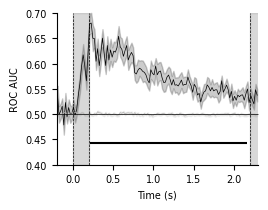

In [7]:
plt.rcParams['font.size'] = 7
plt.rcParams["legend.fontsize"] = 7

zoomfac = 1

cm = 1/2.54

# Plot it:
fig, ax = plt.subplots(1, figsize=(6.6*cm*zoomfac,5*cm*zoomfac))

plot_score_per_factor(factor='Ecc',
                      data=data_plot.reset_index(),
                      plt_dict=plt_dict['stimon'], 
                      scoring='roc_auc',
                      sign_clusters=sign_cluster_times,
                      p_lvl=p_val_cbp,
                      ci_func='se',
                      ylims=[0.4, 0.7],
                      n_boot=10000, ax=ax)
#ax.legend(title='Decoding Target', labels=['Load: 2 vs. 4', 'chance', 'p < .01'], loc=1)

# handles, labels = ax.get_legend_handles_labels()
n_sgn_clu = None if len(sign_cluster_times['All']) <= 1 else -(len(sign_cluster_times['All'])+1)
# ax.legend(handles=handles[1:n_sgn_clu], title='Decoding Target', labels=['Load: 2 vs. 4', 'chance', '$\it{p}$ < ' + "{0:.2f}".format(p_val_cbp)[1:]], loc=1)

fpath = op.join(config.paths['plots'], '09_temporal_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'AUC-Load_overall.pdf')
plt.savefig(fname)

Extract the values for the highest decoding accuracy

In [8]:
decod_scores = data_plot[data_plot.Ecc == 'All'].groupby('time').agg(
                acc_mean=("score", np.mean),
                acc_sd=("score", np.std)
).reset_index()

In [9]:
acc_df.columns = [f'{t:.3f}' for t in times]

acc_df['subID'] = sub_list_str

In [10]:
import scipy

def ci95(x, returnval='both'):
    m = np.mean(x)
    s = np.std(x)
    t_crit = np.abs(scipy.stats.t.ppf((1-0.95)/2, len(x)-1))
    upper = m+s*t_crit/np.sqrt(len(x))
    lower = m-s*t_crit/np.sqrt(len(x))
    if returnval == 'both':
        out = (lower, upper)
    elif returnval == 'lower':
        out = lower
    elif returnval == 'upper':
        out = upper
    return out


df = acc_df.melt(id_vars=['subID'], var_name='time', value_name='score')  # put into long format
decod_summary = (df.groupby('subID')
        .agg(max=('score', np.max))
        .merge(df, left_on='max', right_on='score')
        .drop(labels='score', axis='columns')
        .groupby('subID')
        .agg(maxScore=('max', np.mean),
             maxScoreTime=('time', np.mean))
        .reset_index()
        .melt(id_vars=['subID'])
        .groupby('variable')
        .agg(mean=('value',  np.mean),
             median=('value',  np.median),
             sd = ('value', np.std),
             ci_lower = ('value', lambda x: ci95(x, returnval='lower')),
             ci_upper = ('value', lambda x: ci95(x, returnval='upper')))
)
decod_summary



,mean,median,sd,ci_lower,ci_upper
variable,,,,,
maxScore,0.787077,0.793707,0.049860,0.764928,0.809226
maxScoreTime,0.357571,0.309000,0.174307,0.280140,0.435003


In [11]:
decod_max = decod_scores[decod_scores.acc_mean == np.max(decod_scores.acc_mean)]

helpers.extract_var("decod_sensorspace_avg_peak_mean", decod_max.acc_mean.iloc[0], exp_format='.2f')
helpers.extract_var("decod_sensorspace_avg_peak_sd", decod_max.acc_sd.iloc[0], exp_format='.2f')
helpers.extract_var("decod_sensorspace_avg_peak_t", decod_max.time.iloc[0] * 1000, exp_format='.3f')
helpers.extract_var("decod_sensorspace_peak_mean", decod_summary.loc['maxScore', 'mean'], exp_format='.2f')
helpers.extract_var("decod_sensorspace_peak_sd", decod_summary.loc['maxScore', 'sd'], exp_format='.2f')
helpers.extract_var("decod_sensorspace_peak_cilower", decod_summary.loc['maxScore', 'ci_lower'], exp_format='.2f')
helpers.extract_var("decod_sensorspace_peak_ciupper", decod_summary.loc['maxScore', 'ci_upper'], exp_format='.2f')
helpers.extract_var("decod_sensorspace_peak_t_median",
                    decod_summary.loc['maxScoreTime', 'median'] * 1000,
                    exp_format='.0f')
helpers.extract_var("decod_sensorspace_peak_t_sd",
                    decod_summary.loc['maxScoreTime', 'sd'] * 1000,
                    exp_format='.2f')
helpers.extract_var("decod_sensorspace_peak_t_cilower",
                    decod_summary.loc['maxScoreTime', 'ci_lower'] * 1000,
                    exp_format='.2f')
helpers.extract_var("decod_sensorspace_peak_t_ciupper",
                    decod_summary.loc['maxScoreTime', 'ci_upper'] * 1000,
                    exp_format='.2f')


In [12]:
helpers.extract_var("decod_sensorspace_sign_cluster_t_start", sign_cluster_times['All'][0][0] * 1000, 
                    exp_format=".0f")
helpers.extract_var("decod_sensorspace_sign_cluster_t_end", sign_cluster_times['All'][0][1] * 1000,
                    exp_format=".0f")

In [13]:
# %%
eccs = cond_dict['Ecc']

data_dict = load_decod_res_per_ecc(sub_list_str, eccs, picks_str='All')
data_dict_chance = load_decod_res_chance_per_ecc(sub_list_str, eccs, picks_str='All')  # for simplicity we only use the data from one condition

In [14]:
# Prepare data for plotting with seaborn:
results_df_list = list()
for ecc in eccs:
    times = data_dict[ecc]['times']
    acc = np.asarray(data_dict[ecc]['scores'])
    acc_df = pd.DataFrame(acc)
    acc_df.columns = times
    acc_df['subID'] = sub_list_str
    df = acc_df.melt(id_vars=['subID'], var_name='time', value_name='score')  # put into long format
    df['Ecc'] = ecc
    results_df_list.append(df)
data_plot = pd.concat(results_df_list)


In [15]:
# Add CMCI correction
grav = data_plot.copy().set_index(['time', 'subID']).groupby('time').mean()  
grav.columns = ['grandavg']
subavg = df.copy().groupby(['time', 'subID']).mean()
subavg.columns = ['subavg']
adj_factor = grav.join(subavg)
adj_factor['adj_factor'] = adj_factor.grandavg - adj_factor.subavg
df = data_plot.set_index(['time', 'subID']).join(adj_factor)
df['score_corrected'] = df.score + df.adj_factor



In [16]:

# add chance level data:
acc_chance = np.asarray(data_dict_chance['EccM']['scores_chance'])
acc_df_chance = pd.DataFrame(acc_chance)
acc_df_chance.columns = times
acc_df_chance['subID'] = sub_list_str
df_chance = acc_df_chance.melt(id_vars=['subID'], var_name='time', value_name='score')  # put into long format
df_chance['Ecc'] = 'Chance'
# for compatibility with corrected actual values:
df_chance['score_corrected'] = df_chance['score']
df_chance = df_chance.set_index(['time', 'subID'])
data_plot = pd.concat([df, df_chance])


In [17]:

idx_cbp_times = (times >= 0.2) & (times <= 2.2)
cbp_times = times[idx_cbp_times]

# run CBP to find differences from chance:
for ecc in cond_dict['Ecc']:
    data = np.asarray(data_dict[ecc]['scores']) - np.asarray(data_dict_chance[ecc]['scores_chance'])
    t_values, clusters, p_values = run_cbp_test(data[:, idx_cbp_times])
    idx_sign_clusters = np.argwhere(p_values<p_val_cbp)
    sign_cluster_times[ecc] = [cbp_times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_clusters]
    

In [18]:
df_per_ecc = []
for ecc in eccs:
    times = data_dict[ecc]['times']
    acc = np.asarray(data_dict[ecc]['scores'])
    acc_df = pd.DataFrame(acc)
    acc_df.columns = [f'{t:.3f}' for t in times]
    acc_df['subID'] = sub_list_str
    acc_df['ecc'] = ecc
    df_per_ecc.append(acc_df)

acc_df_ecc = pd.concat(df_per_ecc)
df = acc_df_ecc.melt(id_vars=['subID', 'ecc'], var_name='time', value_name='score')  # put into long format


In [19]:
decod_summary = (df.groupby(['subID', 'ecc'])
        .agg(max=('score', np.max))
                 .reset_index()
                 .merge(df, left_on=['subID', 'ecc', 'max'], right_on=['subID', 'ecc', 'score'])
                 .drop(labels='score', axis='columns')
                 .groupby(['subID', 'ecc'])
                 .agg(maxScore=('max', np.mean),
                      maxScoreTime=('time', np.median))
                 .reset_index()
                 .rename(columns={'ecc': 'c_Ecc',
                                     'maxScore': 'maxDecodScore_sensorspace',
                                     'maxScoreTime': 'maxDecodScoreTime_sensorspace'})
                )
decod_summary

,subID,c_Ecc,maxDecodScore_sensorspace,maxDecodScoreTime_sensorspace
0,VME_S01,EccL,0.774333,0.729
1,VME_S01,EccM,0.836000,0.409
2,VME_S01,EccS,0.882667,0.229
3,VME_S02,EccL,0.869000,0.389
4,VME_S02,EccM,0.809000,0.189
...,...,...,...,...
58,VME_S26,EccM,0.902500,1.789
59,VME_S26,EccS,0.805000,0.589
60,VME_S27,EccL,0.830167,0.529
61,VME_S27,EccM,0.850167,0.249


In [20]:
#                 .melt(id_vars=['subID', 'ecc'])
#                  .groupby(['ecc', 'variable'])
#                  .agg(mean=('value',  np.mean),
#                       median=('value',  np.median),
#                       sd = ('value', np.std),
#                       ci_lower = ('value', lambda x: ci95(x, returnval='lower')),
#                       ci_upper = ('value', lambda x: ci95(x, returnval='upper')))
                


In [21]:
fpath = op.join(config.paths['06_decoding-sensorspace'],
                             'stimon',
                             'collapsed',
                             'LoadLow_vs_LoadHigh',
                             'roc_auc',
                             'All',
                             'summaries')

helpers.chkmk_dir(fpath)
fname = op.join(fpath, "allsubjects-maxDecodScore_sensorspace.csv")
decod_summary.to_csv(fname, float_format="%.15f", index=False)



### run CBP to find differences between conditions:
Code massively inspired/taken from:  
https://mne.tools/stable/auto_tutorials/stats-source-space/plot_stats_cluster_time_frequency_repeated_measures_anova.html#sphx-glr-auto-tutorials-stats-source-space-plot-stats-cluster-time-frequency-repeated-measures-anova-py


In [22]:
factor_levels = [3]
effects = ["A"]


def stat_fun(*data_):
    return f_mway_rm(
        np.swapaxes(data_, 1, 0),
        factor_levels=factor_levels,
        effects=effects,
        return_pvals=False,
    )[0]


# get data:
scores_list = list()
for i, ecc in enumerate(cond_dict["Ecc"]):
    scores_tmp = data_dict[ecc]["scores"]
    scores_list.append(scores_tmp)
data = np.asarray(scores_list)

# crop to retention interval:
idx_cbp_times = (times >= 0.2) & (times <= 2.2)
cbp_times = times[idx_cbp_times]
data = data[:, : , idx_cbp_times]

# The ANOVA returns a tuple f-values and p-values, we will pick the former.
pthresh = p_val_cbp
f_thresh = f_threshold_mway_rm(len(data[0]), factor_levels, effects, pthresh)
tail = 1  # f-test, so tail > 0
n_permutations = 10000  # Save some time (the test won't be too sensitive ...)
T_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(
    data,
    stat_fun=stat_fun,
    threshold=f_thresh,
    tail=tail,
    n_jobs=-2,
    n_permutations=n_permutations,
    buffer_size=None,
    out_type="mask",
    seed=42,
)

# add sign times to the plotting data dict
idx_sign_diff_clusters = np.argwhere(cluster_p_values < p_val_cbp)
sign_cluster_times["Diff"] = [
    times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_diff_clusters
]


stat_fun(H1): min=0.003058 max=3.725967
Running initial clustering
Found 3 clusters
Permuting 9999 times...


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [23]:
sign_cluster_times

{'All': [array([0.209, 2.169])],
 'EccS': [array([0.209, 0.749])],
 'EccM': [array([0.209, 0.269]), array([0.409, 0.909]), array([1.009, 1.109])],
 'EccL': [array([0.209, 0.269]),
  array([0.369, 0.829]),
  array([0.869, 1.069]),
  array([1.109, 1.209])],
 'Diff': []}

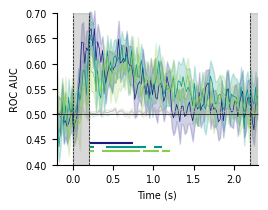

In [24]:
# %%

plt.rcParams['font.size'] = 7
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['svg.fonttype'] = 'none'



# crop to relevant times:
data_plot = data_plot.reset_index()
data_plot = data_plot[(data_plot.time > plt_dict['stimon']['xmin']) & 
                      (data_plot.time < plt_dict['stimon']['xmax'])]


# Plot it:
def ci_func(vec):
    # we want to plot the SEM, so we calculate the according alpha level:
    alpha = 1 - ((scipy.stats.norm.cdf(1) - 0.5) * 2)
    return get_cmci(vec, 3, alpha)

fig, ax = plt.subplots(1, figsize=(6.6*cm,5*cm))
plot_score_per_factor('Ecc', data=data_plot, 
                      plt_dict=plt_dict['stimon'], 
                      scoring='roc_auc', 
                      sign_clusters={ecc: sign_cluster_times[ecc] for ecc in 
                          cond_dict['Ecc']},
                      p_lvl=p_val_cbp,
                      ci_func=ci_func,
                      ylims=[0.4, 0.7],
                      n_boot=10000,
                      ax=ax)
# custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['EccS'], lw=0.5),
#                 matplotlib.lines.Line2D([0], [0], color=config.colors['EccM'], lw=0.5),
#                 matplotlib.lines.Line2D([0], [0], color=config.colors['EccL'], lw=0.5),
#                 matplotlib.lines.Line2D([0], [0], color=config.colors['Chance'], lw=0.5)]
# ax.legend(handles=custom_lines,title='Eccentricity', labels=['4°', '9°', '14°', 'chance'], loc=1)


fpath = op.join(config.paths['plots'], '09_temporal_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'AUC-Load_per_Ecc.pdf')
plt.savefig(fname)

# Plot the patterns of the decoder

We first normalize each pattern vector per subject and timepoint:

In [25]:
# %matplotlib qt

picks = "All"

ecc_cond = ""  # 'EccL' # <<<< '' (aka empty string): all eccentricities

sub_patterns, times = load_patterns(
    sub_list_str, f"LoadLow{ecc_cond}_vs_LoadHigh{ecc_cond}", picks_str=picks
)
sub_patterns_norm = np.zeros_like(sub_patterns)
# normalize them by L2 norm to allow for unbiased averages:
sub_patterns_norm = sub_patterns / np.linalg.norm(
    sub_patterns, axis=1, ord=2, keepdims=True
)



Next, we average per timepoint across subjects and normalize once more per timepoint (so we can meaningfully use one color scale):

In [26]:
sub_patterns_avg = sub_patterns_norm.copy().mean(axis=0)
sub_patterns_avg_norm = sub_patterns_avg / np.linalg.norm(
    sub_patterns_avg, axis=0, ord=2, keepdims=True
)


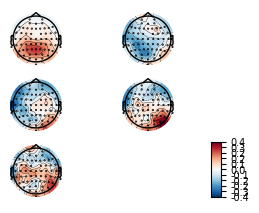

In [27]:
# Build new pseudo Evoke obj:
dummy_epos_info = get_evoked_info(picks_str='All')

sub_patterns_evo = EvokedArray(sub_patterns_avg_norm, dummy_epos_info)
sub_patterns_evo.times = times

times_plot = [0.25, 0.75, 1.0, 1.25, 1.75]

fig, ax = plt.subplots(3,3, figsize=(6.6*cm,5*cm), gridspec_kw={'width_ratios': [10, 10, 1]})

# fig = plt.figure()
# ax = fig.add_gridspec(3,3)

#ax_ = ax.flatten()

# ax_cb = fig.add_subplot(ax[2,2])
# ax_cb.tick_params(labelsize=30)

# for tt in times_plot:
#     axi = fig.add_subplot(ax)

aaxx = [[0,0], [0,1], [1,0], [1,1], [2,0]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#04E762", "white", "#6F2665"])

for tt, axi in zip(times_plot, aaxx):
    #axii = fig.add_subplot(axi)
    t_plot = [tt]
    plt_load = sub_patterns_evo.plot_topomap(times = t_plot, 
                                    scalings=1, 
                                    units='',
                                    title='',  # f"{ecc_cond} -- Decod. Target: {config.labels['Load']}",
                                    cmap = 'RdBu_r',  # cmap, # ,
                                    vmin = -0.4,
                                    vmax=0.4,
                                    contours=10,
                                    ch_type='eeg',
                                    extrapolate='head',
                                    axes=[ax[axi[0], axi[1]], ax[2,2]],
                                    show=False)
    ax[axi[0], axi[1]].set_title('')
# cb = ax.figure.colorbar(plt_load, ax=ax_cb)
fig.delaxes(ax[0][2])
fig.delaxes(ax[1][2])
fig.delaxes(ax[2][1])
plt.show()

Save it:

In [28]:
fpath = op.join(config.paths['plots'], '09_temporal_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'LoadLow{ecc_cond}_vs_LoadHigh{ecc_cond}_patterns_avg.pdf')
plt_load.savefig(fname)

Plot it for each subject separately.
We sort the order of the plots by the average decoding accuracy in the 
significant time window. 

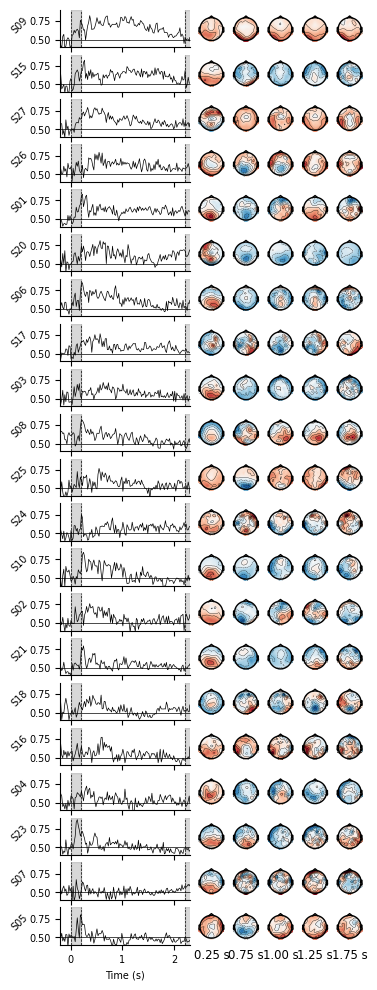

In [40]:
nsubs = len(sub_list_str)

t_idx = [(times > sign_cluster_times['All'][0][0]) & (times < sign_cluster_times['All'][0][1])]

mean_scores = data_dict_all['All']['scores'][:,t_idx[0]].mean(axis=1)
sorted_scores_w_idx = sorted(((v, i) for i, v in enumerate(mean_scores)), reverse=True)
max_decod_idx = [sswi[1] for sswi in sorted_scores_w_idx]

fig, axes = plt.subplots(nsubs, len(times_plot) + 1, figsize=(8*cm,25*cm),
                         gridspec_kw={'width_ratios': [5, 1, 1, 1, 1, 1]})
for i,ax in enumerate(axes):
    idx = max_decod_idx[i]
    sub_patterns_ = sub_patterns_norm[idx,:,:].squeeze()
    
    # get dummy epos.info file to get electrode locations
    dummy_epos_info = get_evoked_info(picks_str='All')

    # Build new pseudo Evoke obj:
    sub_patterns_evo = EvokedArray(sub_patterns_, dummy_epos_info)
    sub_patterns_evo.times = times

    time_format="%0.2f s"
    plt_load_all = sub_patterns_evo.plot_topomap(times = times_plot, 
                                       scalings=1, 
                                       units='',
                                       title='',
                                       cmap = 'RdBu_r',
                                       vmin = -0.4,
                                       vmax=0.4,
                                       contours=10,
                                       sensors=False,
                                       time_format=time_format,
                                       ch_type='eeg',
                                       colorbar=False,
                                       extrapolate='local',
                                       axes=ax[1:],
                                       show=False)
    # Show times only for bottom row:
    for a in ax[1:]:
        if i == (len(axes)-1):
            a.set_title(a.get_title(), y=-1)
        else:
            a.set_title("")
    acc = np.asarray(data_dict_all['All']['scores'])
    acc_df = pd.DataFrame(acc)
    acc_df.columns = times
    df = acc_df.iloc[idx:idx+1,:].melt(var_name='time', value_name='score')  # put into long format
    df['Ecc'] = 'All'
    data_plot = df
    plot_score_per_factor(factor='Ecc',
                        data=data_plot.reset_index(),
                        plt_dict=plt_dict['stimon'], 
                        scoring='roc_auc',
                        sign_clusters=[],
                        p_lvl=p_val_cbp,
                        ylims=[0.4, 0.9],
                        ci_func=None,
                        n_boot=1,
                        ax=ax[0])
    ax[0].set_ylabel(sub_list_str[idx].split('_')[1], rotation=45)
    if i != (len(axes)-1):
        ax[0].set_xlabel("")
        ax[0].set_xticklabels([])
    

Save it:

In [43]:
fpath = op.join(config.paths['plots'], '09_temporal_decoding')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'LoadLow_vs_LoadHigh_ScoresAndPatterns_allsubjects.pdf')
plt_load_all.savefig(fname)